# Adjust index returns for inflation to get real returns

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
wb <- WorldBank()
indices <- Indices()

### get rate of inflation from the WorldBank data-set

In [2]:
# see example: https://nbviewer.jupyter.org/github/shyams80/plutons/blob/master/docs-R/WorldBank.ipynb

wb$Meta() %>%
    filter(COUNTRY_NAME == "India" & INDICATOR_NAME %like% "CPI%") %>%
    select(INDICATOR_NAME, COUNTRY_KEY, INDICATOR_KEY) %>%
    print(n=Inf)

# Source:   lazy query [?? x 3]
# Database: NORWAY:StockVizUs:R
  INDICATOR_NAME                          COUNTRY_KEY INDICATOR_KEY
  <chr>                                         <int>         <int>
1 CPI Price, nominal                              135             3
2 CPI Price, nominal, seas. adj.                  135             5
3 CPI Price, % y-o-y, nominal, seas. adj.         135             6


In [4]:
# we need the CPI Price, % y-o-y, nominal, seas. adj.
cpiInflation <- wb$TimeSeries() %>%
    filter(COUNTRY_KEY == 135 & INDICATOR_KEY == 6) %>%
    select(YEAR, VALUE) %>%
    collect() %>%
    arrange(YEAR) %>%
    as.data.frame()

print(cpiInflation)

   YEAR   VALUE
1  1987  8.7938
2  1988  9.3960
3  1989  3.2747
4  1990  8.9651
5  1991 13.8644
6  1992 11.7933
7  1993  6.3642
8  1994  6.3400
9  1995 11.3395
10 1996  8.8972
11 1997  5.6487
12 1998  4.4739
13 1999  5.9058
14 2000  5.9895
15 2001  3.6844
16 2002  5.2034
17 2003  4.3249
18 2004  3.8532
19 2005  3.7438
20 2006  6.0617
21 2007  5.9915
22 2008  8.5729
23 2009  9.7268
24 2010 10.3605
25 2011  8.3140
26 2012  9.3823
27 2013 10.1005
28 2014  6.4232
29 2015  4.9105
30 2016  4.9489
31 2017  3.3259
32 2018  3.3429


### get NIFTY 50 total-return index returns from the Indices data-set

In [5]:
indexName <- 'NIFTY 50 TR'
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

annRets <- 100*annualReturn(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP))

df1 <- data.frame(annRets)
df1$YEAR <- year(index(annRets))

print(df1)

           yearly.returns YEAR
1999-12-30      24.398669 1999
2000-12-29     -13.364088 2000
2001-12-31     -15.048927 2001
2002-12-31       5.336092 2002
2003-12-31      76.611426 2003
2004-12-31      13.035473 2004
2005-12-30      38.633169 2005
2006-12-29      41.900536 2006
2007-12-31      56.804842 2007
2008-12-31     -51.271464 2008
2009-12-31      77.590783 2009
2010-12-31      19.224497 2010
2011-12-30     -23.807885 2011
2012-12-31      29.434881 2012
2013-12-31       8.072455 2013
2014-12-31      32.899200 2014
2015-12-31      -3.013065 2015
2016-12-30       4.394821 2016
2017-12-29      30.266177 2017
2018-12-31       4.638185 2018
2019-09-12       2.225001 2019


In [6]:
# merge the two

allData <- merge(df1, cpiInflation, by='YEAR')
names(allData) <- c('YEAR', 'INDEX', 'INFLATION')
allData$REAL <- allData$INDEX - allData$INFLATION
print(allData)

   YEAR      INDEX INFLATION        REAL
1  1999  24.398669    5.9058  18.4928692
2  2000 -13.364088    5.9895 -19.3535877
3  2001 -15.048927    3.6844 -18.7333273
4  2002   5.336092    5.2034   0.1326921
5  2003  76.611426    4.3249  72.2865256
6  2004  13.035473    3.8532   9.1822731
7  2005  38.633169    3.7438  34.8893691
8  2006  41.900536    6.0617  35.8388359
9  2007  56.804842    5.9915  50.8133419
10 2008 -51.271464    8.5729 -59.8443636
11 2009  77.590783    9.7268  67.8639829
12 2010  19.224497   10.3605   8.8639969
13 2011 -23.807885    8.3140 -32.1218846
14 2012  29.434881    9.3823  20.0525810
15 2013   8.072455   10.1005  -2.0280447
16 2014  32.899200    6.4232  26.4759999
17 2015  -3.013065    4.9105  -7.9235647
18 2016   4.394821    4.9489  -0.5540791
19 2017  30.266177    3.3259  26.9402767
20 2018   4.638185    3.3429   1.2952846


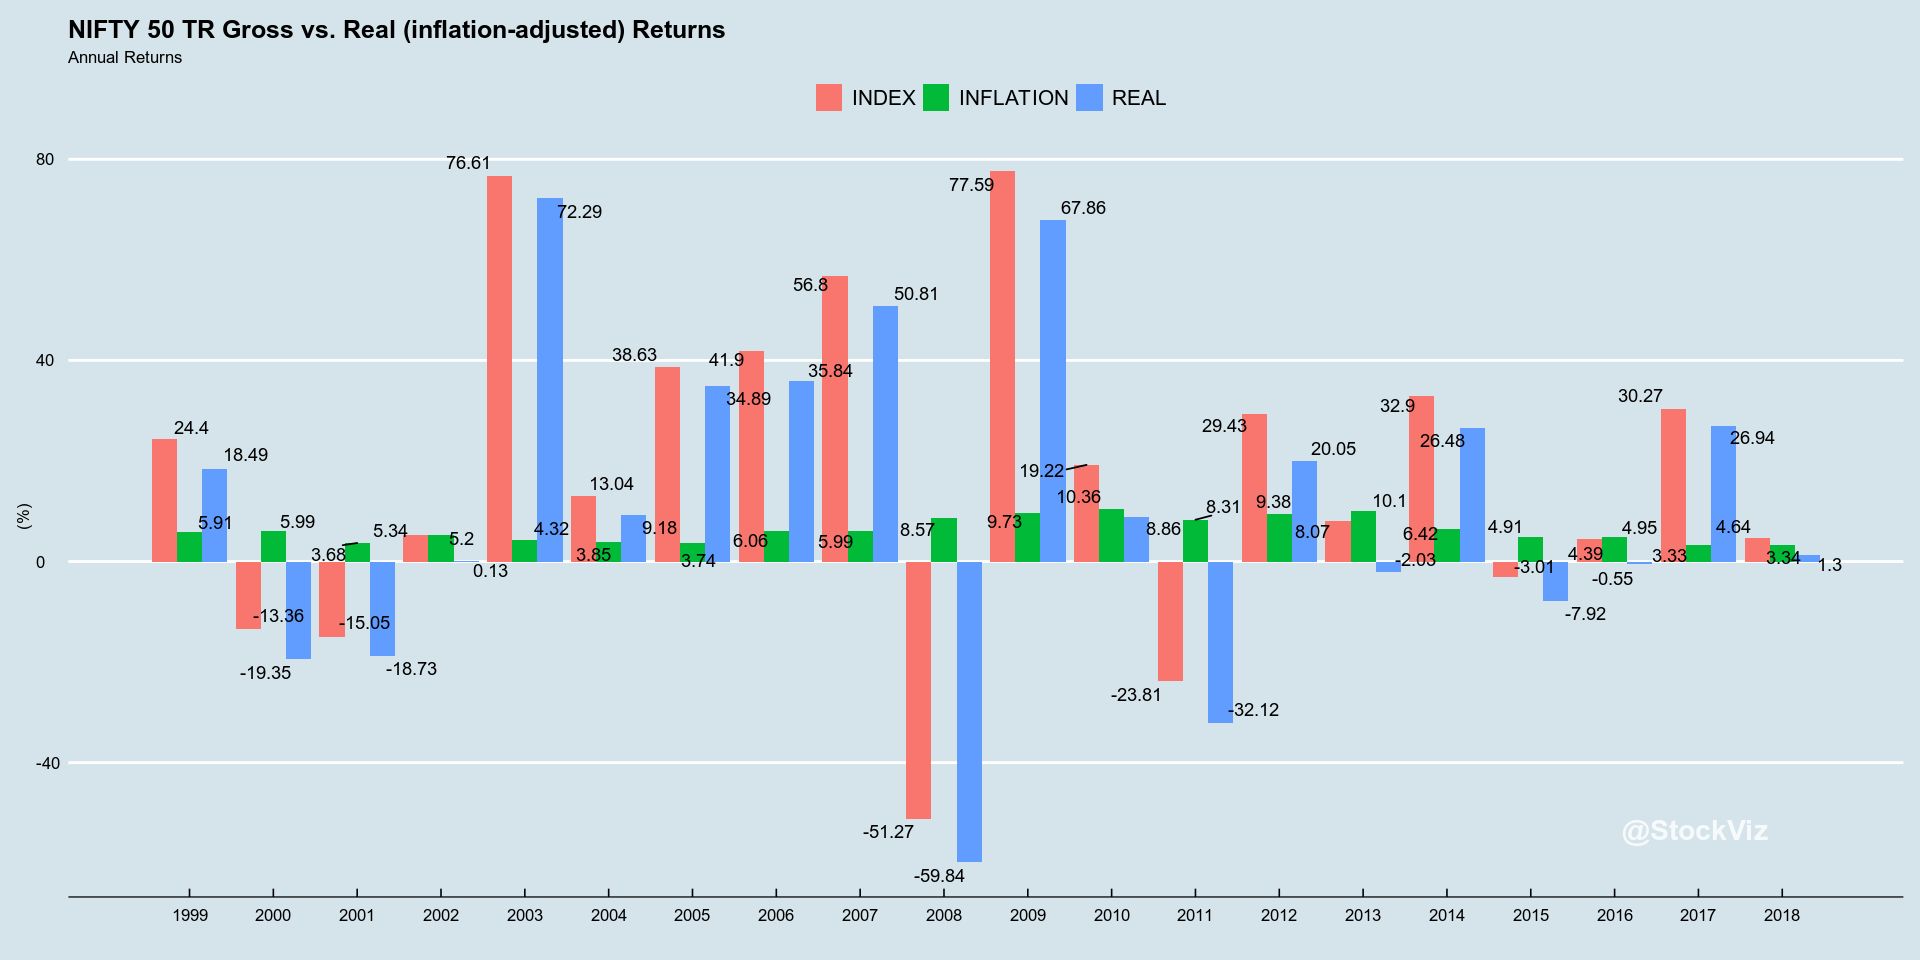

In [7]:
# plot the data

mDf <- melt(allData, id='YEAR')
ggplot(mDf, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=allData$YEAR, breaks=allData$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("%s Gross vs. Real (inflation-adjusted) Returns", indexName), 
         subtitle="Annual Returns") +
    annotate("text", x=max(allData$YEAR), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [8]:
### calculate rolling 5-year inflation adjusted retuns
rYr <- 5

#cumulative
rollingRets <- 100*rollapply(allData$REAL/100, rYr, Return.cumulative)
print(sprintf("%d-year rolling returns (not annualized):", rYr))
print(rollingRets)
print("Stats:")
print(summary(rollingRets))

[1] "5-year rolling returns (not annualized):"
 [1]  33.972898  23.445956 106.475982 245.128649 419.810303  21.154649
 [7]  86.271098  50.332205 -24.879607 -40.201596  45.896493   9.924741
[13]  -7.026395  36.212470  44.027297  48.912880
[1] "Stats:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -40.20   18.35   40.12   68.72   59.32  419.81 


In [9]:
#annualzied

annRollingRets <- (1+rollingRets/100)^(1/rYr) - 1
annRollingRets <- 100* annRollingRets

print(sprintf("%d-year rolling annualized returns:", rYr))
print(annRollingRets)
print("Stats:")
print(summary(annRollingRets))

[1] "5-year rolling annualized returns:"
 [1]  6.023806  4.302657 15.604279 28.113885 39.049354  3.912553 13.247623
 [8]  8.495170 -5.560959 -9.772709  7.847224  1.910537 -1.446527  6.375931
[15]  7.569453  8.289526
[1] "Stats:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -9.773   3.412   6.973   8.373   9.683  39.049 


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)